# Recommendations with IBM

In this notebook, we use recommendation engines on real data from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle
from collections import defaultdict
import progressbar
import os 
from IPython.display import HTML
import re
import warnings
warnings.simplefilter("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
 
nltk.download('stopwords')
print(stopwords.words('english'))


%matplotlib inline
root_path = os.path.dirname(os.getcwd())
0

df = pd.read_csv(rf'{root_path}/data/user-item-interactions.csv')
df_content = pd.read_csv(rf'{root_path}/data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z635177\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [320]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

> For a first impression of the data it is useful to look at the general information of the datasets > such as no of records, dtypes or missing values

> The first dataset looks at the user interaction with the articles

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [322]:
no_of_users = df["email"].unique().shape[0]
no_of_article_id = df["article_id"].unique().shape[0]

print(f"There are {no_of_users} of different users in the dataset")
print(f"There are {no_of_article_id} of different articles in the dataset")

There are 5149 of different users in the dataset
There are 714 of different articles in the dataset


> The second dataset contains the general content of the articles. The two datasets can be connected via the article id

In [323]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [324]:
no_of_unique_articles = len(df_content["article_id"].unique())
print(f'''Apparently the "articles_community.csv" contains duplicates: The dataset shows 1056 
      records for the article_id, but filtering out only the unique article_id, we come up with 
      {no_of_unique_articles} unique article_ids''')

Apparently the "articles_community.csv" contains duplicates: The dataset shows 1056 
      records for the article_id, but filtering out only the unique article_id, we come up with 
      1051 unique article_ids


In [325]:
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

> To subsume the general interaction of users with the articles, we create a visual, a histplot, and a more theoretical collection of descriptive statistics

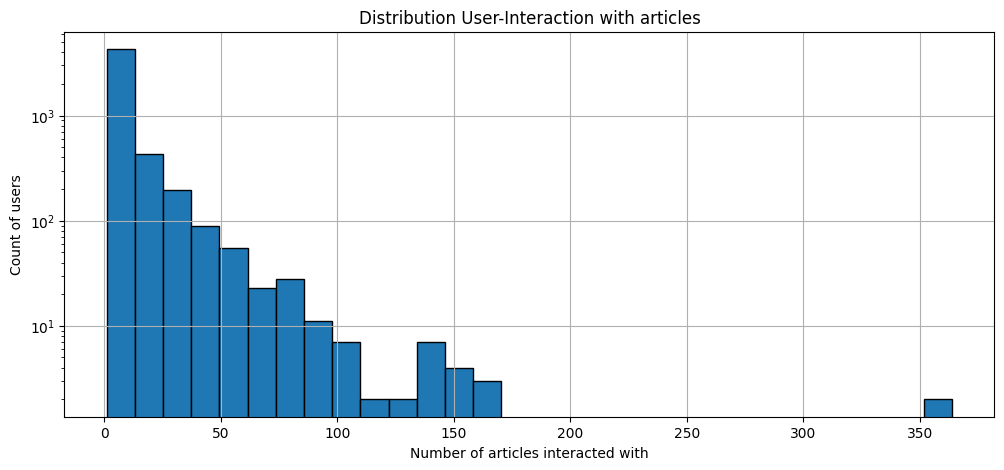

In [326]:
interaction_per_user = df.groupby("email")["article_id"].count()

fig, sub = plt.subplots(1, 1, figsize = (12,5))

sub.hist(
    interaction_per_user, 
    bins = 30, 
    log = True,
    edgecolor = "black"
    )

sub.grid()

sub.set_title("Distribution User-Interaction with articles")
sub.set_ylabel("Count of users", fontdict = {"size":10})
sub.set_xlabel("Number of articles interacted with", fontdict = {"size":10});

In [327]:
interaction_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [328]:
# Fill in the median and maximum number of user_article interactios below
median_val = np.median(interaction_per_user) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = np.max(interaction_per_user) # The maximum number of user-article interactions by any 1 user is ______.

In [329]:
print(f"The median value is {median_val}")
print(f"The max value is {max_views_by_user}")

The median value is 3.0
The max value is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

> As already stated above, the dataset "articles_community.csv" contains duplicates. In the following, we treat the duplicate values in the dataset:

In [330]:
# Find and explore duplicate articles
grouped_data = df_content.groupby(["article_id"])["doc_status"].count().sort_values(ascending=False)
grouped_data[grouped_data>=2]

article_id
232    2
398    2
221    2
577    2
50     2
Name: doc_status, dtype: int64

In [331]:
# Remove any rows that have the same article_id - only keep the first
df_content_cleaned = df_content.drop_duplicates(subset="article_id", keep = "first")

df_content_cleaned.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [332]:
#number of unique articles that have at least one interaction
len(df["article_id"].unique())

714

In [333]:
#number of unique articles on the IBM platform
len(df_content["article_id"].unique())

1051

In [334]:
#number of unique users
list_a = df["email"].drop_duplicates().value_counts().sort_values(ascending=False).index.tolist()
list_b = df["email"].drop_duplicates().tolist()

In [335]:
np.setdiff1d(list_b, list_a)

array(['nan'], dtype='<U40')

In [336]:
df["email"].nunique()

5148

In [337]:
#number of user-article interactions
df.shape

(45993, 3)

In [338]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [339]:
df.groupby("article_id")["email"].count().sort_values(ascending=False).head(5)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [340]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [341]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [342]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [343]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [344]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df[df["article_id"].isin(get_top_article_ids(n, df))]["title"].drop_duplicates().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby("article_id")["user_id"].count().sort_values(ascending = False).index[:n].tolist()
     
    return top_articles # Return the top article ids

In [345]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [346]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [347]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(["user_id", "article_id"])["article_id"].count().unstack(fill_value=0)
    user_item[user_item>1] = 1

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [348]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [349]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [350]:
user_item.shape, user_item.loc[1].T.shape

((5149, 714), (714,))

In [351]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_vals = user_item.dot(user_item.loc[user_id].T)

    # sort by similarity
    most_similar_users = similarity_vals.sort_values(ascending=False).index.tolist()

    # create list of just the ids
    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users # return a list of the users in order from most to least similar
        

In [352]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 131, 3870, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [353]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [354]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_ids = [float(article) for article in article_ids]
    article_names = df[df["article_id"].isin(article_ids)]["title"].drop_duplicates().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id]>0].index.tolist()
    article_ids = [str(article) for article in article_ids]

    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # articles the user has already seen
    articles_read = np.array(get_user_articles(user_id)[0])
    closest_neighbors = find_similar_users(user_id)

    # array for recommendations
    recs = np.array([])

    # loop over the closest neighbor to find the articles the user might like but hasn't read
    for neighbor in closest_neighbors:

        #get the articles which the neighbor read
        neighbs_articles_read = np.array(get_user_articles(neighbor)[0])

        #get the articles which the neighbor read but the user didn't read yet
        new_recs = np.setdiff1d(neighbs_articles_read, articles_read, assume_unique=True)
        
        #update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0))

        # if we have enough recs exit the loop
        if len(recs) > m-1:
            break

    return recs[:m] # return your recommendations for this user_id    

In [355]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\r\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\r\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [356]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [357]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity_vals = user_item.dot(user_item.loc[user_id].T).sort_values(ascending=False).reset_index().rename({0:"similarity"}, axis = 1)
    interactions = df.groupby(["user_id"], as_index = False)["article_id"].count().rename({"article_id":"num_interactions"}, axis = 1)

    neighbors_df = pd.merge(similarity_vals, interactions, on = "user_id", how = "left")
    
    # sorting
    neighbors_df = neighbors_df.sort_values(by = ["similarity", "num_interactions"], ascending=False)
    # remove the own user's id    
    neighbors_df.drop(neighbors_df[neighbors_df["user_id"] == user_id].index, axis = 0, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    #get sorted top neighbors
    neighbors = get_top_sorted_users(user_id=user_id)
        
    #get articles
    articles_read = np.array(get_user_articles(user_id)[0])
    article_interactions = df.groupby('article_id').count()['user_id']
    
    recs = np.array([])

    #loop over the closest neighbor to find the articles the user might like from the most similar users
    for neighbor in neighbors["user_id"]:

        #get the articles which the neighbor read
        neighbs_articles_read = np.array(get_user_articles(neighbor)[0])

        #get the articles which the neighbor read but the user didn't read yet
        new_recs = [float(i) for i in np.setdiff1d(neighbs_articles_read, articles_read, assume_unique=True)]
        
        #update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0))

        if len(recs) > m:
            break
    
    recs = article_interactions[article_interactions.index.isin(recs)].sort_values(ascending=False).index.tolist()[:m]
    rec_names = get_article_names(article_ids=recs)
    
    return recs, rec_names

In [358]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [359]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(user_id=1)["user_id"].values[0].item() # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(user_id=131)["user_id"].values[9].item() # Find the 10th most similar user to user 131

In [360]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

> Looking at the functions above in the user-user-based collaborative filter section, one of the main basis components for the creation of recommendations is the user-article-matrix.
We use this matrix to calculate the similarities of the reading-history of the given user with reading-history of the other users. Subsequently based on the most similar users and their reading history, we recommend the unknown articles to the given user which haven been read by the most similar users.<br>
> Confronted with a new user this above mentioned calculation can't be done because of a lack of reading history on the side of the new user<br>
> A better approach would be to use Content-based Recommendation: In this method we're using information which is specifically known for the given user (here: information of the user or for the article) to suggest relevant recommendation to the user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [361]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(n = 10)]

In [362]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [363]:
df_content_cleaned.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [364]:
#define tokenizer 
def tokenize(txt):
    """Tokenizer for the article title

    Args:
        txt (str): respective title of the article
    return:
        calc_tokens (list): list of calculated tokens        
    """

    #normalize + tokenize txt
    text = re.sub(r"[^a-zA-Z0-9]", " ", txt.lower())
    tokens = word_tokenize(text)

    #lemmatize + filter 
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]

    final_tokens = [t for t in lemmatized_tokens if len(t)>2]


    return final_tokens

In [365]:
tokenize("i think it should work if I look at this sentence")

['think', 'work', 'look', 'sentence']

In [366]:
def create_base_df(df = df, df_content = df_content_cleaned):
    """Create two base dataframe for further calculations.

    Args:
        df (pandas.DataFrame): user-interaction with articles. Defaults to df.
        df_content (pandas.DataFrame): detailed article information incl. articles without user-interaction. Defaults to df_content.
    """

    #define rlvnt cols
    relevant_cols_df = ["article_id", "title"]
    relevant_cols_df_content = ["article_id", "doc_full_name"]

    #find all articles with active interactions + Articles without active interactions
    df_ = pd.concat(
        [df[relevant_cols_df],
                df_content[relevant_cols_df_content].rename({"doc_full_name": "title"}, axis = 1)],
        axis = 0,
        ignore_index=True
    ).drop_duplicates(subset = "article_id")

    df_ = df_.reset_index(drop = True).sort_values(by = "article_id", ascending = True)

    #vectorize while applying tokenizer
    vect = TfidfVectorizer(tokenizer=tokenize, token_pattern=None)
    vect_titles = vect.fit_transform(df_["title"].values)
    
    df_tfidf = pd.DataFrame(vect_titles.toarray(), columns=[*vect.vocabulary_])

    #prepare final df
    df_articles = pd.concat([df_, df_tfidf], axis = 1)

    return df_, df_articles

In [367]:
df_complete, df_articles = create_base_df()

In [368]:
df_articles

,article_id,title,detect,malfunctioning,iot,sensor,streaming,analytics,communicating,data,...,welcome,caused,challenger,disaster,marriage,tourism,region,1948,2010,1000
271,0.0,detect malfunctioning iot sensors with streami...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
714,1.0,Communicating data science: A guide to present...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,2.0,"this week in data science (april 18, 2017)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,3.0,DataLayer Conference: Boost the performance of...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
625,4.0,analyze ny restaurant data using spark in dsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1440.0,world marriage data,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1441.0,world tourism data by the world tourism organi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,1442.0,worldwide county and region - national account...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474,1443.0,worldwide electricity demand and production 19...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [369]:
def calc_similarity(df=df_articles):
    """Calculate the similarities between each article combination

    Args:
        df (pandas.DataFrame): Tokenized articles DataFrame. Defaults to df_articles.
    """
    #get data relevant for similarity calc
    article_tfidf_matrix = np.array(df.iloc[:, 2:])

    #calc similarities
    articles_similarities = article_tfidf_matrix.dot(article_tfidf_matrix.T)

    #wrap result in dataframe
    similarity_matrix = pd.DataFrame(
        articles_similarities,
        index = df["article_id"],
        columns = df["article_id"]       
    )

    return similarity_matrix

article_similarities = calc_similarity()

In [370]:
article_similarities.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2.0,0.0,0.0,1.000000,0.0,0.085452,0.0,0.0,0.0,0.065478,0.069995,...,0.099734,0.00000,0.078045,0.085969,0.0,0.0,0.0,0.000000,0.0,0.000000
3.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4.0,0.0,0.0,0.085452,0.0,1.000000,0.0,0.0,0.0,0.108169,0.094057,...,0.274767,0.04959,0.215013,0.051658,0.0,0.0,0.0,0.052037,0.0,0.047647


In [371]:
def make_content_recs(interacted_articles = None, df=df, m=10, df_smly=article_similarities, thd = 0.2):
    """Make either content-based recommendations for the user (if interacted_articles are provided) or an 
    initial rank-based proposal for users without any interaction 

    Args:
        interacted_articles (list): list of articles_ids already interacted with. be careful to provide existant article_ids. Defaults to None.
        df (pandas.DataFrame, optional): Article-user interaction dataframe. Defaults to df.
        m (int, optional): number of recommendations. Defaults to 10.
        df_smly (pandas.DataFrame, optional): tfidf measures similarity matrix for articles based on titles. Defaults to article_similarities.
        thd (float, optional): degree of similarity between the recommended articles and the interacted articles. the higher the thd, the more similar the article titles. Defaults to 0.2.

    Returns:
        recs (list): list of recommended article ids
        rec_names (list): list of the article titles recommended
    """

    recs = []
    popularity_sorted_articles = df.groupby("article_id")["title"].count().sort_values(ascending = False)

    #Option 1: user has already read some articles (content-based)
    if interacted_articles is not None: 
        new_recs = df_smly.loc[interacted_articles].sum()
        new_recs = new_recs[new_recs>=thd].sort_values(ascending = False).index
        
        recs = np.setdiff1d(ar1 = new_recs, ar2 = np.array(interacted_articles), assume_unique=True)
        recs = popularity_sorted_articles[popularity_sorted_articles.index.isin(recs)].index.tolist()       

    #Option 2: user has not yet read any articles (rank-based)
    else:
        recs = get_top_article_ids(n = m)

    rec_names = get_article_names(article_ids=recs) 
    return recs[:m], rec_names[:m]   


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

> The approach shown above is based on a NLP-method to measure the similarity between the different articles in the repo, a content-based recommendation as well as an rank-based recommendation approach.<br> 

> 1. A clean article dataframe as well as a tfidf Vector for each article is created
> 2. Based on 1. the calculation of a similarity matrix (article_id vs. article_id) is executed
> 3. Within the calculation of the recommendation for a user, we distinguish two cases:
* Option A: A user has had some interactions with articles yet (read them)
* Option B: A user has not had any interactions yet

> For Option A, the function takes a list of interacted articles and with a content-based recommendation approach (with the help of the calculated similarity matrix) and a sorting logic based on popularity of the articles to come up with a recommendation. The user can steer the degree of similarity between the recommendation and the articles already interacted with by customizing the parameter "thd".

> For Option B, the list of interacted articles is not provided and a recommendation is calculated via a rank-based approach in which m of the most popular articles are chosen for recommendation.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [372]:
# make recommendations for a brand new user
make_content_recs()

([1429.0,
  1330.0,
  1431.0,
  1427.0,
  1364.0,
  1314.0,
  1293.0,
  1170.0,
  1162.0,
  1304.0],
 ['healthcare python streaming application demo',
  'use deep learning for image classification',
  'apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'analyze energy consumption in buildings',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for logistic regression model',
  'insights from new york car accident reports',
  'finding optimal locations of new store using decision optimization'])

In [373]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(interacted_articles = [1427,232,1364,70], thd = 0.3)

([379.0, 2.0, 871.0, 158.0, 191.0, 1225.0, 951.0, 569.0, 1289.0, 48.0],
 ['overfitting in machine learning: what it is and how to prevent it',
  'country statistics: health expenditures',
  'shiny 0.12: interactive plots with ggplot2',
  'd3heatmap: interactive heat maps',
  'this week in data science (march 28, 2017)',
  'this week in data science (april 18, 2017)',
  'data structures related to machine learning algorithms',
  'external debt stocks, total (dod, current us$) by country',
  'data science experience demo: modeling energy usage in nyc',
  'how can data scientists collaborate to build better business'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [374]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [375]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [376]:
print(f"The max val of the matrix is {user_item_matrix.max().max()}")
print(f"The min val of the matrix is {user_item_matrix.min().min()}")

The max val of the matrix is 1.0
The min val of the matrix is 0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [377]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

> Within the lesson, the data provided was about a user-community which evaluated movies within their interaction time with the platform.<br>
The data structure was characterized by multiple missing (null) values which showed up when a user did not evaluated the respective movie. The procedure above (numpy SVD) does not work for data structures with missing values and therefore Funk-SVD has been used to approximate the final result. 

> In addition to that, the lesson's data structure contained float values for each interaction (the score a user gave to a respective movie) and in the current problem (user_item_matrix) were confronted with binary values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

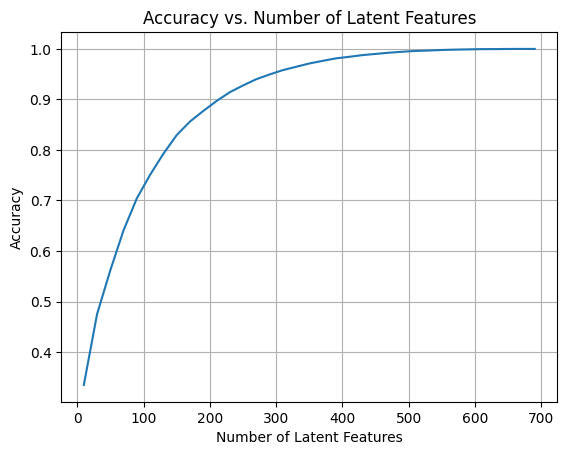

In [378]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.grid();

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [379]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #create the user-item matrix for df_train and df_test
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index.tolist()
    test_articles = user_item_test.columns.tolist()

    return user_item_train, user_item_test, test_idx, test_articles

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [380]:
user_item_train.shape

(4487, 714)

In [381]:
user_item_test.shape

(682, 574)

In [382]:
#how many users are in the test set and in the train set -> how many users can be predicted? 682-662 = 20
user_item_test.shape[0] - len(np.setdiff1d(user_item_test.index, user_item_train.index, assume_unique=True))

20

In [383]:
#How many users are in the test set, but NOT in the train set -> how many user cannot be predicted 
len(np.setdiff1d(user_item_test.index, user_item_train.index, assume_unique=True))

662

In [384]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [385]:
#User item matrix: 1 if user has read the article 0 if not
user_item_train

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4484,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [386]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [387]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [388]:
#Rows that match the test set
test_idx = user_item_test.index
predictable_test_idx = user_item_train.index.isin(test_idx)

u_test = u_train[predictable_test_idx, :]

#Columns matching the test set
test_col = user_item_test.columns
col_idx = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idx]

In [389]:
u_test

array([[-9.12128414e-03, -1.04593665e-02, -3.44661555e-05, ...,
        -3.35867400e-05,  6.84888168e-04, -2.26188845e-03],
       [-4.23484921e-02, -8.80195536e-02,  2.37441056e-02, ...,
        -8.06243240e-04,  5.13291148e-04, -5.39714692e-03],
       [-1.08548005e-02, -4.07260013e-02, -6.40519993e-03, ...,
         1.89206898e-03,  3.30881031e-03,  3.82920030e-03],
       ...,
       [-2.00584196e-02,  4.52035654e-03,  1.40205893e-03, ...,
        -1.89279219e-03, -6.96799303e-04, -6.21813240e-03],
       [-4.34321936e-02,  4.29457303e-02,  3.35667405e-02, ...,
        -3.96698912e-03,  1.18434928e-02, -1.31881273e-02],
       [-1.61097454e-02, -6.66008794e-03,  7.28103953e-03, ...,
        -2.53413867e-04, -6.38776314e-04,  4.87326348e-01]],
      shape=(20, 4487))

In [390]:
vt_test

array([[-2.17234322e-03, -2.50211538e-02, -2.47568584e-03, ...,
        -1.19178349e-03, -1.75764013e-03, -4.04943583e-03],
       [ 2.07052261e-03, -2.21578691e-02,  1.47527709e-03, ...,
         2.10270582e-03,  8.19235025e-03,  1.53390757e-02],
       [-1.12698320e-03, -1.75169207e-03, -4.36025174e-03, ...,
        -5.90100152e-03, -5.73042987e-03, -1.64098364e-02],
       ...,
       [ 0.00000000e+00, -4.64893598e-17,  1.21154746e-17, ...,
        -2.62208966e-17,  1.96160474e-16,  7.70329344e-17],
       [ 0.00000000e+00,  3.82005493e-17,  1.04747656e-18, ...,
         1.31230507e-16,  6.40165207e-17, -9.99441332e-17],
       [ 0.00000000e+00, -7.13443613e-18,  5.43108641e-17, ...,
        -1.52631768e-16, -2.17170216e-16,  2.68060947e-17]],
      shape=(714, 574))

Just to remember how the SVD factorizes the data<br>
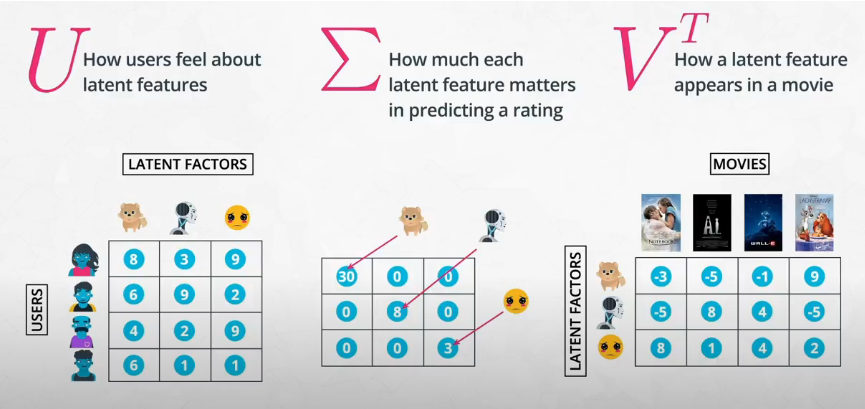

In [391]:
train_idx = user_item_train.index
row_idx = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idx]

In [392]:
s_train.shape

(714,)

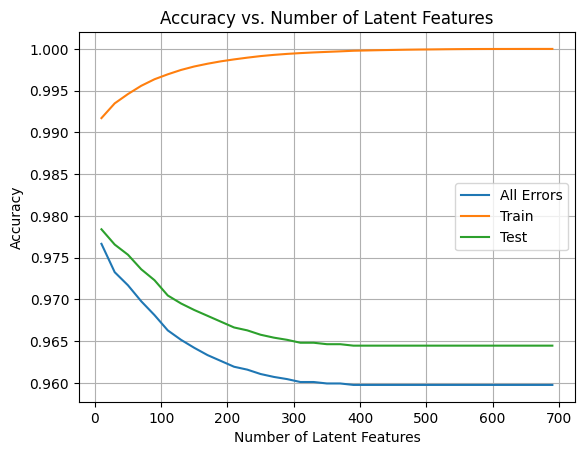

In [393]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []

for k in latent_feats:

    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

    # take dot product to calculate the original matrix
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))

    all_errs.append(
        1 - (
            (np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))
            /(sub_user_item_test.shape[0]*sub_user_item_test.shape[1]))
    )

    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.grid()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

> In general, the accuracy of the model seems to be with around 90 % quite high. But we have to keep in mind, that the user-item matrix is binary and imbalanced as there are more combinations without interactions (=0) as with interaction (=1) <br>
> Looking at the "Accuracy vs. Number of Latent Features" Plot above, we can observe that the accuracy on the test set drops with increasing number of latent features.On the other side, it is doubtful that this model has a robust generalization power as we're only testing the model on 20 records because only this number is convenient for the prediction as ony this number is in the train as well as in the test set.
<br><br>
A possible next step to determine if the recommendations with the approaches above are an improvement to the current situation would be the use of A/B Testing. We could split up the user in the live system into a group which is exposed to the recommendation system and in another which isn't exposed to it and compare the relevant metrics to determine if the use of the system is an improvement.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [395]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1